https://stackoverflow.com/questions/14177744/how-does-perspective-transformation-work-in-pil

### AFFINE TRANSFORMATION

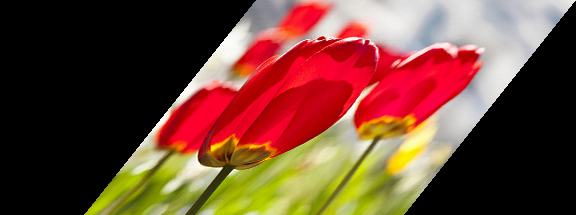

In [33]:

from PIL import Image

img = Image.open("tulips.png")
width, height = img.size
m = 0.8
xshift = abs(m) * width
new_width = width + int(round(xshift))
img.transform((new_width, height), Image.Transform.AFFINE,(1, m, -xshift if m > 0 else 0, 0, 1, 0), Image.Resampling.BICUBIC)


In [10]:
(new_width, height)

(480, 215)

In [31]:
(1, m, -xshift if m > 0 else 0, 0, 1, 0)

(1, 0.8, -256.0, 0, 1, 0)

In [12]:
xshift

160.0

In [37]:
find_coeffs([(0, 0), (256, 0), (256, 256), (0, 256)],[(0, 0), (256, 0), (new_width, height), (xshift, height)])

array([ 1.00000000e+00,  8.00000000e-01, -2.85294011e-12, -6.11923706e-15,
        6.71875000e-01,  2.15316653e-12, -1.73472348e-17, -7.81250000e-04])

### PRESPECTIVE TRANSFORMATION

The 8 transform coefficients (a, b, c, d, e, f, g, h) correspond to the following transformation:

x' = (ax + by + c) / (gx + hy + 1)
y' = (dx + ey + f) / (gx + hy + 1)


To apply a perspective transformation you first have to know four points in a plane A that will be mapped to four points in a plane B. With those points, you can derive the homographic transform. By doing this, you obtain your 8 coefficients and the transformation can take place.

In [38]:
import numpy

def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=numpy.float64)
    B = numpy.array(pb).reshape(8)
    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
    return numpy.array(res).reshape(8)

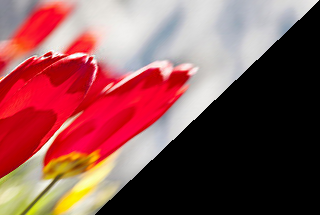

In [40]:
coeffs = find_coeffs(
        [(0, 0), (256, 0), (256, 256), (0, 256)],
        [(0, 0), (256, 0), (new_width, height), (xshift, height)])

img.transform((width, height), Image.Transform.PERSPECTIVE, coeffs,
        Image.Resampling.BICUBIC)

In [44]:
import numpy as np

def create_perspective_transform_matrix(src, dst):
    """ Creates a perspective transformation matrix which transforms points
        in quadrilateral ``src`` to the corresponding points on quadrilateral
        ``dst``.

        Will raise a ``np.linalg.LinAlgError`` on invalid input.
        """
    # See:
    # * http://xenia.media.mit.edu/~cwren/interpolator/
    # * http://stackoverflow.com/a/14178717/71522
    in_matrix = []
    for (x, y), (X, Y) in zip(src, dst):
        in_matrix.extend([
            [x, y, 1, 0, 0, 0, -X * x, -X * y],
            [0, 0, 0, x, y, 1, -Y * x, -Y * y],
        ])

    A = np.matrix(in_matrix, dtype=np.float64)
    B = np.array(dst).reshape(8)
    af = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.append(np.array(af).reshape(8), 1).reshape((3, 3))


def create_perspective_transform(src, dst, round=False, splat_args=False):
    """ Returns a function which will transform points in quadrilateral
        ``src`` to the corresponding points on quadrilateral ``dst``::

            >>> transform = create_perspective_transform(
            ...     [(0, 0), (10, 0), (10, 10), (0, 10)],
            ...     [(50, 50), (100, 50), (100, 100), (50, 100)],
            ... )
            >>> transform((5, 5))
            (74.99999999999639, 74.999999999999957)

        If ``round`` is ``True`` then points will be rounded to the nearest
        integer and integer values will be returned.

            >>> transform = create_perspective_transform(
            ...     [(0, 0), (10, 0), (10, 10), (0, 10)],
            ...     [(50, 50), (100, 50), (100, 100), (50, 100)],
            ...     round=True,
            ... )
            >>> transform((5, 5))
            (75, 75)

        If ``splat_args`` is ``True`` the function will accept two arguments
        instead of a tuple.

            >>> transform = create_perspective_transform(
            ...     [(0, 0), (10, 0), (10, 10), (0, 10)],
            ...     [(50, 50), (100, 50), (100, 100), (50, 100)],
            ...     splat_args=True,
            ... )
            >>> transform(5, 5)
            (74.99999999999639, 74.999999999999957)

        If the input values yield an invalid transformation matrix an identity
        function will be returned and the ``error`` attribute will be set to a
        description of the error::

            >>> tranform = create_perspective_transform(
            ...     np.zeros((4, 2)),
            ...     np.zeros((4, 2)),
            ... )
            >>> transform((5, 5))
            (5.0, 5.0)
            >>> transform.error
            'invalid input quads (...): Singular matrix
        """
    try:
        transform_matrix = create_perspective_transform_matrix(src, dst)
        error = None
    except np.linalg.LinAlgError as e:
        transform_matrix = np.identity(3, dtype=np.float64)
        error = "invalid input quads (%s and %s): %s" %(src, dst, e)
        error = error.replace("\n", "")

    to_eval = "def perspective_transform(%s):\n" %(
        splat_args and "*pt" or "pt",
    )
    to_eval += "  res = np.dot(transform_matrix, ((pt[0], ), (pt[1], ), (1, )))\n"
    to_eval += "  res = res / res[2]\n"
    if round:
        to_eval += "  return (int(round(res[0][0])), int(round(res[1][0])))\n"
    else:
        to_eval += "  return (res[0][0], res[1][0])\n"
    locals = {
        "transform_matrix": transform_matrix,
    }
    locals.update(globals())
    exec(to_eval in locals, locals)
    res = locals["perspective_transform"]
    res.matrix = transform_matrix
    res.error = error
    return res

In [45]:
create_perspective_transform_matrix([(0, 0), (256, 0), (256, 256), (0, 256)],
        [(0, 0), (256, 0), (new_width, height), (xshift, height)])

array([[ 1.00000000e+00,  8.00000000e-01, -2.85294011e-12],
       [-6.11923706e-15,  6.71875000e-01,  2.15316653e-12],
       [-1.73472348e-17, -7.81250000e-04,  1.00000000e+00]])